# 🖥️ Choosing an appropriate timestep and integrator 

In Parcels, we can simulate virtual particles through time. Kernels which compute a process as a function of time, such as advection, can do so by numerically integrating the process over each timestep `dt`. In this guide we explore how to control the numerical accuracy of a Parcels simulation by choosing an integration method and a timestep `dt`.

```{note}
This notebook is based on the [workshop on writing custom Kernels](https://github.com/Parcels-code/10year-anniversary-session2/blob/main/advection_and_windage.ipynb) from the 10-year Parcels event.
```

## Integrating advection
Parcels comes with a number of built-in advection Kernels. These kernels integrate the virtual particles' position in time as a function of a velocity field, as described in the [Parcels workflow explanation of kernels](../../getting_started/explanation_concepts.md#3-kernels). 

**Considerations**
- dt from velocity field (linear interpolation in time, aliasing)
- dt from CFD condition (function of U, dx/dy)
- convergence? of integration (sample particles, full length of simulation)
- Realizations vs distributions
- Numerical accuracy vs flow separation.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import parcels

/var/folders/fd/p7j_05zx409dzmtfjjjnjgfh0000gn/T/ipykernel_23854/2983398643.py:5: UserWarning: This is an alpha version of Parcels v4. The API is not stable and may change without deprecation warnings.
  import parcels


## FieldSet resolution
In this example, we use the daily velocity fields at 1/12th degree horizontal resolution from the Copernicus Marine Service. 

In [86]:
# Load the CopernicusMarine data in the Agulhas region from the example_datasets
example_dataset_folder = parcels.download_example_dataset(
    "CopernicusMarine_data_for_Argo_tutorial"
)

ds_fields = xr.open_mfdataset(f"{example_dataset_folder}/*.nc", combine="by_coords")
ds_fields.load()  # load the dataset into memory

fieldset = parcels.FieldSet.from_copernicusmarine(ds_fields)

print(f"dt = {np.unique(np.diff(ds_fields.time.values).astype("timedelta64[h]"))} hours")
print(f"dlat = {np.unique(np.diff(ds_fields.latitude.values))} degrees")
print(f"dlon = {np.unique(np.diff(ds_fields.longitude.values))} degrees")

INFO: cf_xarray found variable 'uo' with CF standard name 'eastward_sea_water_velocity' in dataset, renamed it to 'U' for Parcels simulation.
INFO: cf_xarray found variable 'vo' with CF standard name 'northward_sea_water_velocity' in dataset, renamed it to 'V' for Parcels simulation.
dt = [24] hours
dlat = [0.08333206 0.08333588] degrees
dlon = [0.08332825 0.08334351] degrees


To compute the Lagrangian integration of advection processes resolved by this velocity field, we must ensure `dt` < 1 day, and `particles.dlon`/`particles.dlat` < 1/12th degree. To ensure the latter, we can use the scale relation: dlon ~ U dt.

In [ ]:
# Use the maximum velocity at the surface to scale dlon/dlat
U_max_surface = np.nanmax(np.hypot(ds_fields.uo[0,0],ds_fields.vo[0,0]))
print(f"U_max = {str(np.round(U_max_surface,2))} m s-1 == {str(np.round(U_max_surface / (1852 * 60) * 1e5,2))}e-5 degrees s-1")

U_max = 1.24 m s-1 == 1.12e-5 degrees s-1


In [85]:
1/12/U_max_surface*(1852 * 60)/3600

np.float32(2.0755265)

dt < 1/12 / U_max

dt < 2 hours

In [6]:
# Particle locations and initial time
npart = 5  # number of particles to be released
initial_release_lons = 32 * np.ones(npart)
initial_release_lats = np.linspace(-32.5, -32, npart, dtype=np.float32)
initial_release_times = np.repeat(
    ds_fields.time.values[0], npart
)  # release all particles at the start time of the fieldset
initial_release_zs = np.repeat(ds_fields.depth.values[0], npart)

In [ ]:
runtime = np.timedelta64(7,"D")    # Total simulation time

advection_schemes = [parcels.kernels.AdvectionEE, parcels.kernels.AdvectionRK2, parcels.kernels.AdvectionRK4]
dt_choices = [np.timedelta64(12,"h"), np.timedelta64(6,"h"), np.timedelta64(1,"h"), np.timedelta64(20,"m"), np.timedelta64(5,"m")]

In [88]:
for advection_scheme in advection_schemes:
    for dt in dt_choices:
        pset = parcels.ParticleSet(fieldset=fieldset, pclass=parcels.Particle,
                                time=initial_release_times,
                                z=initial_release_zs,
                                lat=initial_release_lats,
                                lon=initial_release_lons,
                                )
        outputdt = dt
        chunks = int(runtime/outputdt/2) # Because we will store a lot of positions, to speed up our simulation we need to chunk the output datafile
        
        pfile = parcels.ParticleFile(store=f"output/{advection_scheme.__name__}_dt_{int(dt/np.timedelta64(1,"s"))}s.zarr", outputdt=outputdt, chunks=(len(pset), chunks))

        print(f"Begin simulation for (scheme: {advection_scheme.__name__}, dt={int(dt/np.timedelta64(1,"s"))} s)")
        pset.execute(advection_scheme, runtime=runtime, dt=dt, output_file=pfile)
        print(f"chunks = {(len(pset), chunks)}")

Begin simulation for (scheme: AdvectionEE, dt=43200 s)
INFO: Output files are stored in /Users/Gebruiker/Documents/UU/parcels/Parcels/docs/user_guide/examples/output/AdvectionEE_dt_43200s.zarr
Integration time: 2024-01-07T12:00:00.000000000: 100%|██████████| 604800.0/604800.0 [00:00<00:00, 3935325.98it/s]
chunks = (5, 7)
Begin simulation for (scheme: AdvectionEE, dt=21600 s)
INFO: Output files are stored in /Users/Gebruiker/Documents/UU/parcels/Parcels/docs/user_guide/examples/output/AdvectionEE_dt_21600s.zarr
Integration time: 2024-01-07T18:00:00.000000000: 100%|██████████| 604800.0/604800.0 [00:00<00:00, 1715112.64it/s]
chunks = (5, 14)
Begin simulation for (scheme: AdvectionEE, dt=3600 s)
INFO: Output files are stored in /Users/Gebruiker/Documents/UU/parcels/Parcels/docs/user_guide/examples/output/AdvectionEE_dt_3600s.zarr
Integration time: 2024-01-07T23:00:00.000000000: 100%|██████████| 604800.0/604800.0 [00:01<00:00, 479025.97it/s]
chunks = (5, 84)
Begin simulation for (scheme: Ad

In [89]:
# To compare the results visually, we will need distinct colour maps for each advection scheme and timestep
dt_colours = np.linspace(0,1,len(dt_choices), endpoint=True)
scheme_colours = np.linspace(0,1,len(advection_schemes), endpoint=True)

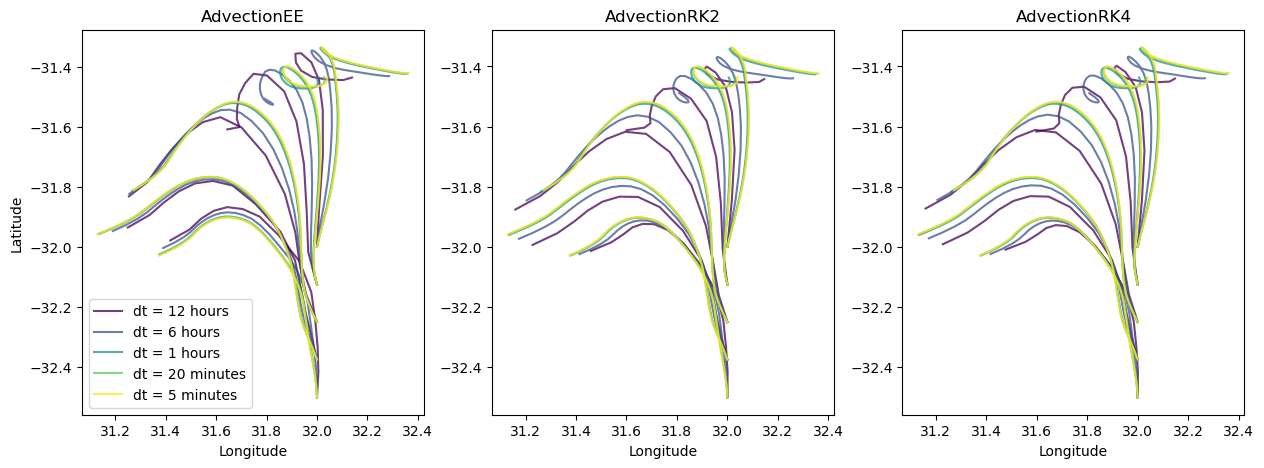

In [90]:
# Let's first compare different timesteps within each advection scheme
fig, axs = plt.subplots(nrows=1, ncols=len(advection_schemes), figsize=(15,5))
for i, advection_scheme in enumerate(advection_schemes):
    axs[i].set_title(f'{advection_scheme.__name__}')
    axs[i].set_xlabel('Longitude')
    for j,dt in enumerate(dt_choices):
        ds = xr.open_zarr(f"output/{advection_scheme.__name__}_dt_{int(dt/np.timedelta64(1,"s"))}s.zarr")
        labels = [f"dt = {str(dt)}"] + [None] * (ds.lon.shape[0] - 1)
        axs[i].plot(ds.lon.T, ds.lat.T, alpha=0.75, color=plt.cm.viridis(dt_colours[j]), label=labels)
    axs[0].legend()
    axs[0].set_ylabel('Latitude')
    #plt.legend()
plt.show()

### Accuracy: separation from more accurate simulation
To quantify the accuracy of the different simulations, we can compute how far each particle deviates from the most accurate simulation. We have no exact solution to this integration, so we have to use our highest resolution simulation as a benchmark.

In [ ]:
def dist_km(lona, lonb, lata, latb):
    """
    Function to calculate the distance between 2 points in km
    Haversine formula used, which assumes the Earth is a sphere.
    source: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
    """

    R = 6371.0 # approximate radius of earth in km

    lat1 = np.radians(lata)
    lon1 = np.radians(lona)
    lat2 = np.radians(latb)
    lon2 = np.radians(lonb)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.square(np.sin(dlat / 2)) + np.cos(lat1) * np.cos(lat2) * np.square(np.sin(dlon / 2))
    c = 2 * np.atan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c

    return distance

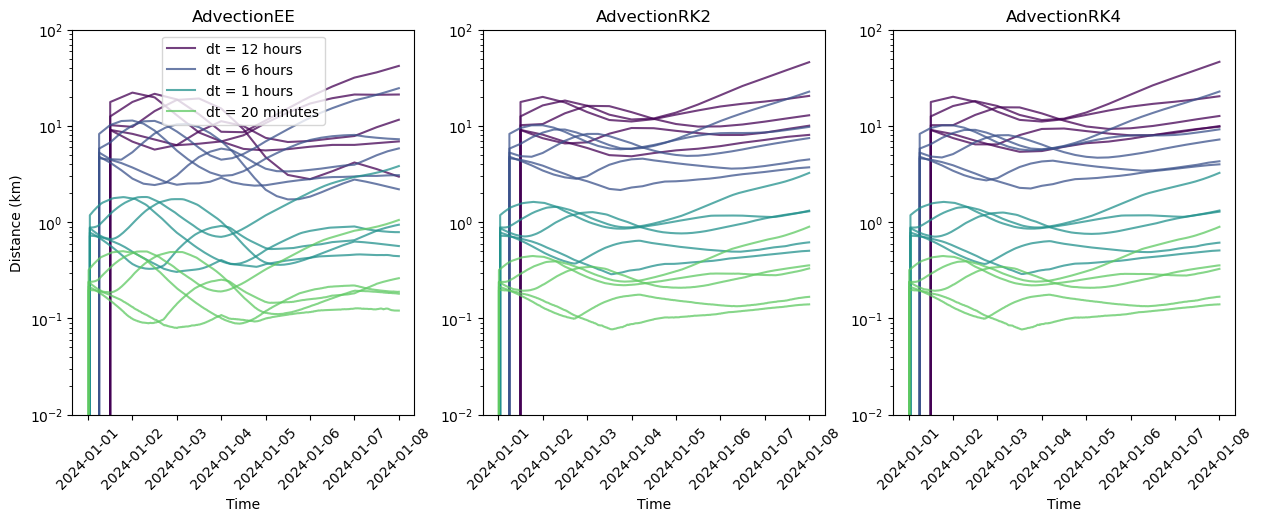

In [127]:
dist_end = np.zeros((len(dt_choices)-1, len(advection_schemes), npart))
# Let's first compare different timesteps within each advection scheme
fig, axs = plt.subplots(nrows=1, ncols=len(advection_schemes), figsize=(15,5))
for i, advection_scheme in enumerate(advection_schemes):
    axs[i].set_title(f'{advection_scheme.__name__}')
    axs[i].set_xlabel('Time')
    axs[i].tick_params("x", rotation=45)
    axs[i].set_yscale('log')
    axs[i].set_ylim(1e-2,1e2)

    # set 5 minute dt as benchmark
    ds_5min = xr.open_zarr(f"output/{advection_scheme.__name__}_dt_300s.zarr")
    for j,dt in enumerate(dt_choices[:-1]):
        ds = xr.open_zarr(f"output/{advection_scheme.__name__}_dt_{int(dt/np.timedelta64(1,"s"))}s.zarr")
        labels = [f"dt = {str(dt)}"] + [None] * (ds.lon.shape[0] - 1)

        # subset 5 minute data to match dt
        lon_5min_sub = ds_5min.lon.where(ds_5min.time.isin(ds.time.values).compute(),drop=True).values
        lat_5min_sub = ds_5min.lat.where(ds_5min.time.isin(ds.time.values).compute(),drop=True).values

        # remove nans
        lon_valid = ds.lon.where(~np.isnan(ds.lon).compute(),drop=True).values
        lat_valid = ds.lat.where(~np.isnan(ds.lat).compute(),drop=True).values

        #compute separation distance between each particle in km
        dist = dist_km(lon_valid,lon_5min_sub,lat_valid,lat_5min_sub)

        # plot 
        time_valid = ds.time.where(~np.isnan(ds.time).compute(),drop=True)
        axs[i].plot(time_valid.T, dist.T, alpha=0.75, color=plt.cm.viridis(dt_colours[j]), label=labels)
        dist_end[j,i] = dist[:,-1]
    axs[0].legend()
    axs[0].set_ylabel('Distance (km)')
plt.show()

### Drifter pair separation: flow conditions
The limitation to numerical accuracy of the integration introduces a positional difference of a certain order of magnitude ($\delta$), as seen in the figure above. After this initial deviation, the time evolution of the separation distance is a feature of the specific flow field. As with the [Lorenz equations](), two initially close particles often separate over time. The rate of separation from a finite perturbation ($\delta$) can be characterized by the _Finite Size Lyapunov Exponent_: DEFINE

We can see that the separation distance of particles with their more accurate counterparts does not keep growing (stochastically) in time, but follows a rather specific time-evolution, as the particles enter different flow conditions. The final accuracy of your simulation may therefore strongly depend on your flow conditions and runtime.

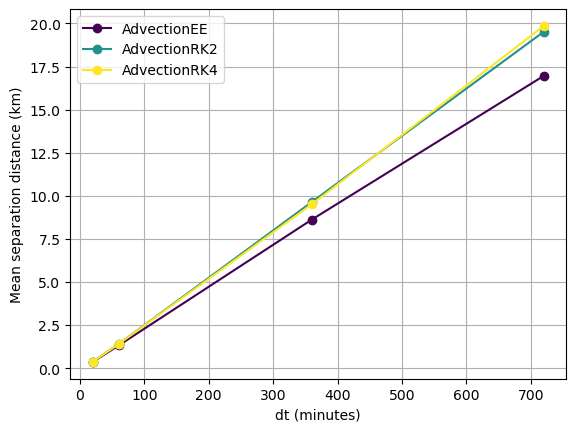

In [ ]:
fig = plt.figure()
ax=plt.axes()
for i, advection_scheme in enumerate(advection_schemes):
    ax.plot((dt_choices[:-1]/np.timedelta64(1,"m")).astype(int), np.mean(dist_end[:,i],axis=1), "-o", color=plt.cm.viridis(scheme_colours[i]), label = f"{advection_scheme.__name__}")
ax.set_ylabel("Mean separation distance (km)")
ax.set_xlabel("dt (minutes)")
ax.legend()
ax.grid()
plt.show()

## Advection schemes

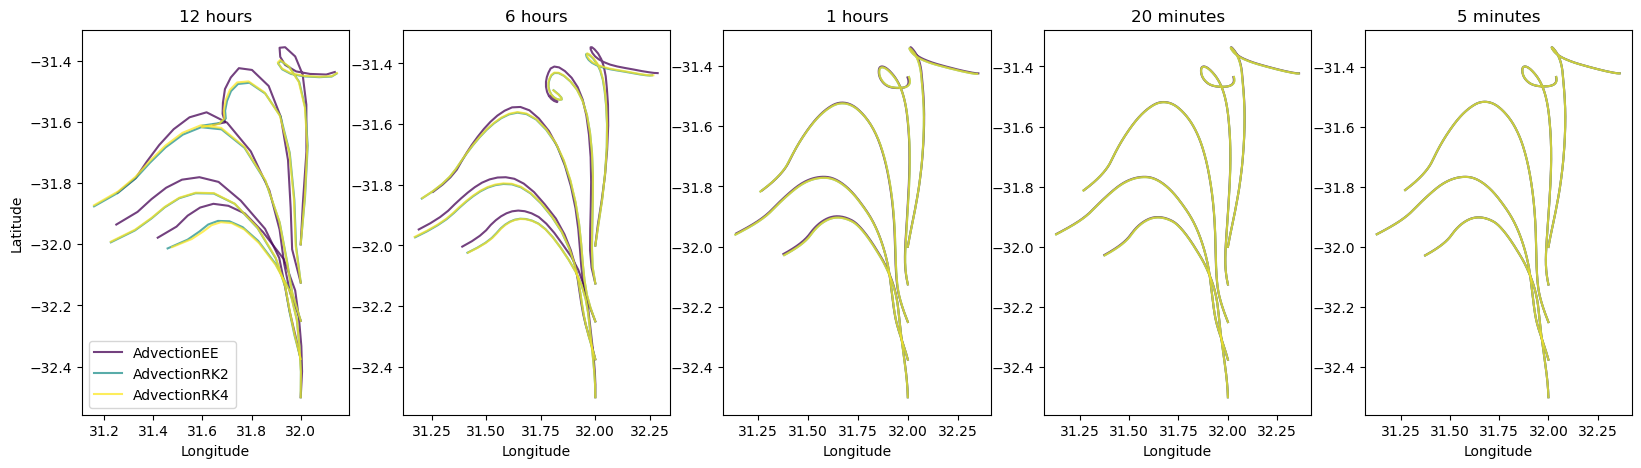

In [132]:
# Now let's compare different advection schemes with the same timestep
fig, axs = plt.subplots(nrows=1, ncols=len(dt_choices), figsize=(20,5))
for i, dt in enumerate(dt_choices):
    axs[i].set_title(f'{str(dt)}')
    axs[i].set_xlabel('Longitude')
    for j,advection_scheme in enumerate(advection_schemes):
        ds = xr.open_zarr(f"output/{advection_scheme.__name__}_dt_{int(dt/np.timedelta64(1,"s"))}s.zarr")
        labels = [f"{advection_scheme.__name__}"] + [None] * (ds.lon.shape[0] - 1)
        axs[i].plot(ds.lon.T, ds.lat.T, alpha=0.75, color=plt.cm.viridis(scheme_colours[j]), label=labels)
    axs[0].legend()
    axs[0].set_ylabel('Latitude')
plt.show()

### Accuracy
Compare with AdvectionRK4. Lagrangian Diagnostics. Great Circle Distance. 

Integration scheme = O(1) error -> Finite Size Lyapunov Exponent takes over.

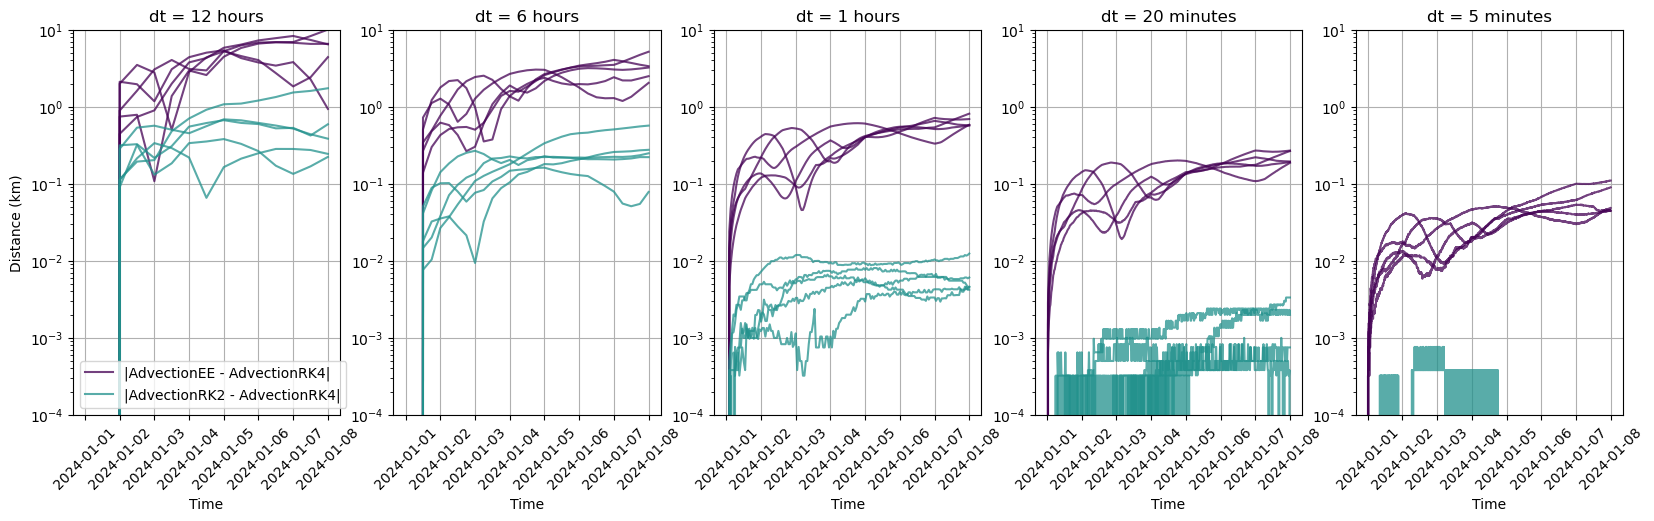

In [146]:
dist_end = np.zeros((len(advection_schemes)-1,len(dt_choices), npart))
# Now let's compare different advection schemes with the same timestep
fig, axs = plt.subplots(nrows=1, ncols=len(dt_choices), figsize=(20,5))
for i, dt in enumerate(dt_choices):
    axs[i].set_title(f'dt = {str(dt)}')
    axs[i].set_xlabel('Time')
    axs[i].tick_params("x", rotation=45)
    axs[i].set_yscale("log")
    axs[i].set_ylim(1e-4,1e1)
    ds_RK4 = xr.open_zarr(f"output/AdvectionRK4_dt_{int(dt/np.timedelta64(1,"s"))}s.zarr")
    for j,advection_scheme in enumerate(advection_schemes[:-1]):
        ds = xr.open_zarr(f"output/{advection_scheme.__name__}_dt_{int(dt/np.timedelta64(1,"s"))}s.zarr")
        labels = [f"|{advection_scheme.__name__} - AdvectionRK4|"] + [None] * (ds.lon.shape[0] - 1)

        # remove nans
        lon_valid_RK4 = ds_RK4.lon.where(~np.isnan(ds_RK4.lon).compute(),drop=True).values
        lat_valid_RK4 = ds_RK4.lat.where(~np.isnan(ds_RK4.lat).compute(),drop=True).values
        lon_valid = ds.lon.where(~np.isnan(ds.lon).compute(),drop=True).values
        lat_valid = ds.lat.where(~np.isnan(ds.lat).compute(),drop=True).values
        dist = dist_km(lon_valid,lon_valid_RK4,lat_valid,lat_valid_RK4)
        time_valid = ds.time.where(~np.isnan(ds.time).compute(),drop=True).values
        axs[i].plot(time_valid.T, dist.T, alpha=0.75, color=plt.cm.viridis(scheme_colours[j]), label=labels)
        dist_end[j,i] = dist[:,-1]
    axs[i].grid()
    axs[0].legend()
    axs[0].set_ylabel('Distance (km)')
plt.show()

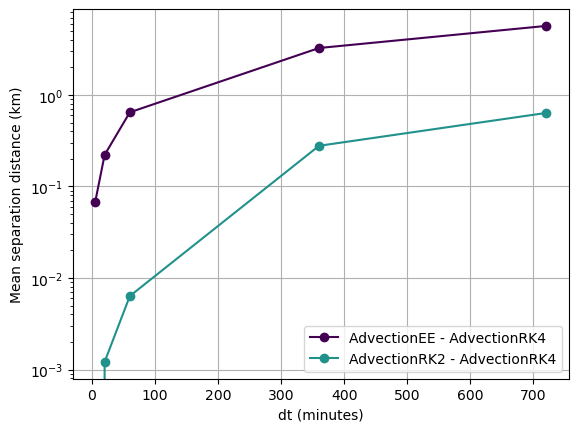

In [151]:
fig = plt.figure()
ax=plt.axes()
ax.plot((dt_choices/np.timedelta64(1,"m")).astype(int), np.nanmean(dist_end[0],axis=1), "-o", color=plt.cm.viridis(scheme_colours[0]), label = "AdvectionEE - AdvectionRK4")
ax.plot((dt_choices/np.timedelta64(1,"m")).astype(int), np.nanmean(dist_end[1],axis=1), "-o", color=plt.cm.viridis(scheme_colours[1]), label = "AdvectionRK2 - AdvectionRK4")
ax.set_ylabel("Mean separation distance (km)")
ax.set_yscale("log")
ax.set_xlabel("dt (minutes)")
ax.legend()
ax.grid()
plt.show()